# Age detection
https://www.pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/
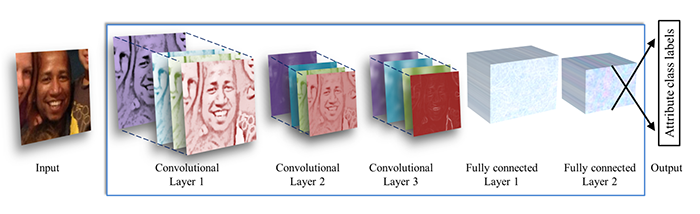

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## Settings

In [2]:
image_folder = 'images/'
face_model = 'face_detector'
age_model = 'age_detector'
min_confidence = 0.998 # Minimum probability to filter weak detections

## Initialization

In [3]:
# Define the list of age buckets our age detector will predict
AGE_BUCKETS = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

# Load our serialized face detector model from disk
prototxtPath = os.path.sep.join([face_model, "deploy.prototxt"])
weightsPath = os.path.sep.join([face_model, "res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# Load our serialized age detector model from disk
prototxtPath = os.path.sep.join([age_model, "age_deploy.prototxt"])
weightsPath = os.path.sep.join([age_model, "age_net.caffemodel"])
ageNet = cv2.dnn.readNet(prototxtPath, weightsPath)

## Age detector

In [4]:
def age_detector(image_path: str):
    """
    Run the age detector on an input image.
    """
    # Load the input image and construct an input blob for the image
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # Pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    
    # Loop over the detections
    for i in range(detections.shape[2]):
        # Extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        
        # Filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > min_confidence:
            # Compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # Extract the ROI of the face and then construct a blob from only the face ROI
            face = image[startY:endY, startX:endX]
            faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),
                                             (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
            
            # Make predictions on the age and find the age bucket with
            # the largest corresponding probability
            ageNet.setInput(faceBlob)
            preds = ageNet.forward()
            i = preds[0].argmax()
            age = AGE_BUCKETS[i]
            ageConfidence = preds[0][i]
            
            # Display the predicted age to our terminal
            text = "Age {} -> {:.2f}%".format(age, ageConfidence * 100)
            print("{}: {}".format(image_path, text))
            
            # Draw the bounding box of the face along with the associated
            # predicted age
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
            
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Validation

images/iu.jpg: Age (4-6) -> 72.06%
images/samuel_l_jackson.png: Age (48-53) -> 69.38%
images/neil_patrick_harris.png: Age (8-12) -> 85.72%
images/natalie-portman.jpg: Age (25-32) -> 60.35%
images/dicaprio.jpg: Age (0-2) -> 61.35%


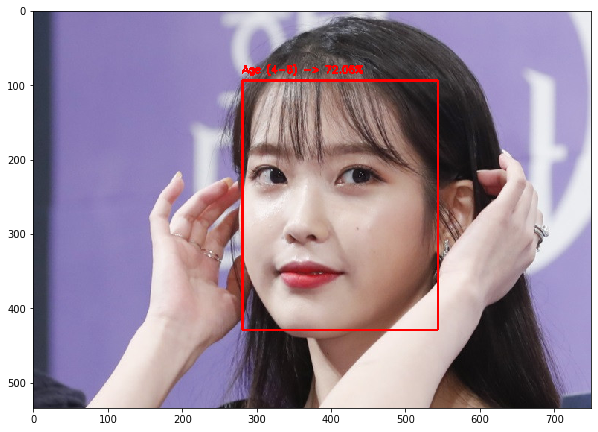

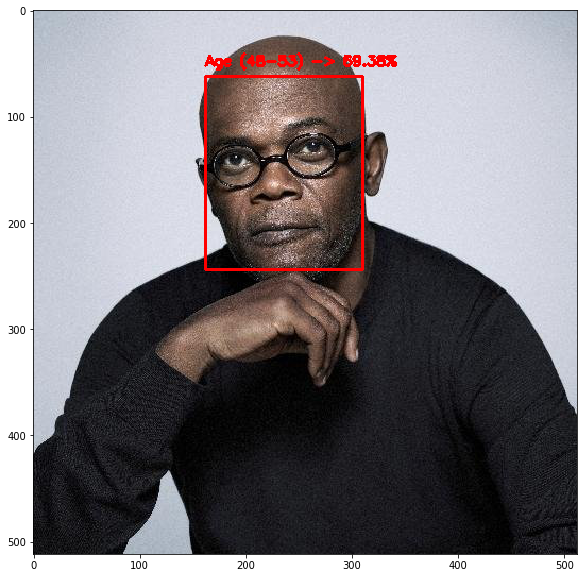

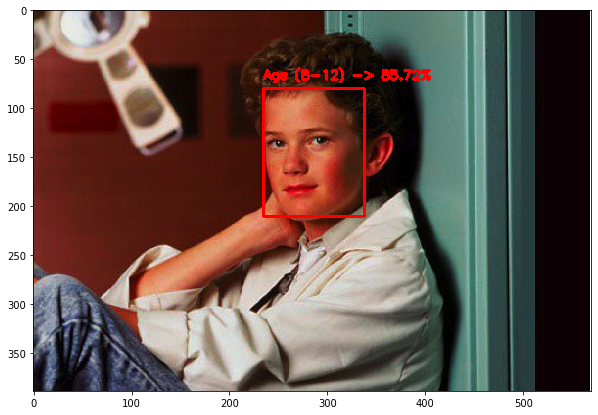

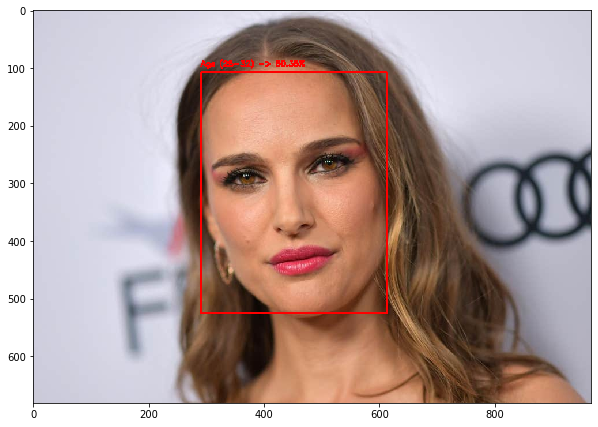

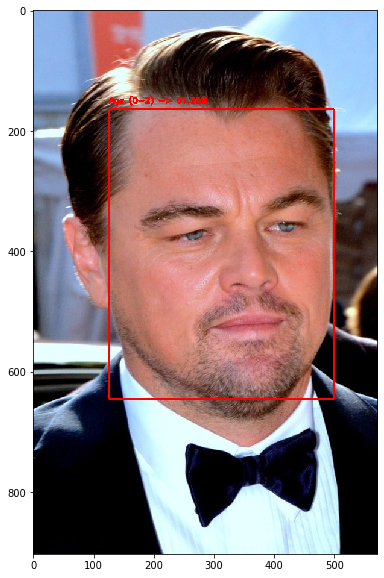

In [5]:
valid_images = [".jpg", ".jpeg", ".gif",".png"]
for f in os.listdir(image_folder):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    age_detector(os.path.join(image_folder, f))